<a href="https://colab.research.google.com/github/udupa-varun/pyimagesearch_uni/blob/main/deep_learning/105/cpu_gpu_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/cpu-gpu-tpu/cpu-gpu-tpu.zip
!unzip -qq cpu-gpu-tpu.zip
%cd cpu-gpu-tpu

--2023-02-24 11:04:25--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/cpu-gpu-tpu/cpu-gpu-tpu.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.181.41, 52.92.137.26, 52.218.234.249, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.181.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263276 (257K) [application/zip]
Saving to: ‘cpu-gpu-tpu.zip’

cpu-gpu-tpu.zip     100%[===================>] 257.11K  1.32MB/s    in 0.2s    

2023-02-24 11:04:26 (1.32 MB/s) - ‘cpu-gpu-tpu.zip’ saved [263276/263276]

/content/cpu-gpu-tpu


In [2]:
import tensorflow as tf
tf.random.set_seed(42)

In [3]:
import os

from tensorflow import reduce_mean
from tensorflow.image import convert_image_dtype
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, InputLayer, Conv2DTranspose
from tensorflow.keras.losses import Reduction, MeanSquaredError
from tensorflow.keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

### Define data pipeline

In [4]:
from tensorflow.python.ops.gen_batch_ops import batch
def pre_process(element):
    # convert image dtype from uint8 to float32
    image = convert_image_dtype(element["image"], dtype=tf.float32)

    # return images as tuple
    return (image, image)

def get_data(data_name, split, batch_size, shuffle_size=None):
    # check for valid split argument
    assert split in ["train", "test"], "Please provide a valid split."

    # check if training split
    if split == "train":
        # get training split
        print("[INFO] downloading the train split...")
        dataset = tfds.load(name=data_name, split=split, try_gcs=True)
        dataset = (
            dataset.map(pre_process)
            .shuffle(shuffle_size)
            .repeat()
            .batch(batch_size)
        )
    
    else:
        # test split
        print("[INFO] downloading the test split...")
        dataset = tfds.load(name=data_name, split=split, try_gcs=True)
        dataset = (
            dataset.map(pre_process)
            .batch(batch_size)
        )

    return dataset

### Define loss

In [5]:
from contextlib import redirect_stderr
class MSELoss():
    def __init__(self, scale):
        # store scalar by which loss is to be scaled
        self.scale = scale
    
    def __call__(self, real, pred):
        # init MSE loss with no reduction
        MSE = MeanSquaredError(reduction=Reduction.NONE)

        # compute loss
        loss = MSE(real, pred)

        # scale loss
        loss = reduce_mean(loss) * (1. / self.scale)

        return loss

### Define model

In [7]:
class AutoEncoder(Model):
    def __init__(self):
        super().__init__()

        # build encoder
        self.encoder = Sequential(
            [
                InputLayer((28, 28, 1)),
                Conv2D(
                    filters=16, 
                    kernel_size=(3, 3), 
                    activation="relu", 
                    padding="same", 
                    strides=2
                ),
                Conv2D(
                    filters=8, 
                    kernel_size=(3, 3), 
                    activation="relu", 
                    padding="same", 
                    strides=2
                ),
            ]
        )

        # build decoder
        self.decoder = Sequential(
            [
                Conv2DTranspose(
                    filters=8, 
                    kernel_size=3, 
                    strides=2, 
                    activation="relu", 
                    padding="same"
                ),
                Conv2DTranspose(
                    filters=16, 
                    kernel_size=3, 
                    strides=2, 
                    activation="relu", 
                    padding="same"
                ),
                Conv2D(
                    filters=1,
                    kernel_size=3,
                    activation="sigmoid",
                    padding="same"
                )
            ]
        )

    def call(self, x):
        # pass input through encoder
        encoded = self.encoder(x)
        # pass output of encoder through decoder
        decoded = self.decoder(encoded)

        # return output from decoder
        return decoded

### Create the config

In [8]:
class config:
    # define dataset name and TFDS flags
    TRAIN_FLAG = "train"
    VALIDATION_FLAG = "test"
    DATA_NAME = "mnist"

    # define batch sizes
    BATCH_SIZE = 128
    TPU_BATCH_SIZE = 8 * 128

    # define shuffle size and number of epochs
    SHUFFLE_SIZE = 10000
    EPOCHS = 5

    # calculate steps per epoch for training set
    STEPS_PER_EPOCH = 60000 // BATCH_SIZE
    TPU_STEPS_PER_EPOCH = 60000 // TPU_BATCH_SIZE

    # calculate steps per epoch for validation set
    VALIDATION_STEPS = 10000 // BATCH_SIZE
    TPU_VALIDATION_STEPS = 10000 // TPU_BATCH_SIZE

    # define optimizer
    OPTIMIZER = "adam"

    # define base output path and build image output paths
    BASE_IMG_PATH = "outputs"
    CPU_IMG_PATH = os.path.join(BASE_IMG_PATH, "cpu.png")
    GPU_IMG_PATH = os.path.join(BASE_IMG_PATH, "gpu.png")
    TPU_IMG_PATH = os.path.join(BASE_IMG_PATH, "tpu.png")

### Train with CPUs
Runtime -> Change runtime type -> Hardware Accelerator -> None

[INFO] loading the training and validation datasets...
[INFO] downloading the train split...
[INFO] downloading the test split...
[INFO] initializing the model...
[INFO] training autoencoder...
Epoch 1/5
468/468 [==============================] - 57s 117ms/step - loss: 0.0326 - val_loss: 0.0036
Epoch 2/5
468/468 [==============================] - 58s 124ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 3/5
468/468 [==============================] - 48s 102ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/5
468/468 [==============================] - 46s 98ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/5
468/468 [==============================] - 46s 99ms/step - loss: 0.0017 - val_loss: 0.0015
[INFO] running inference...
[INFO] evaluating model...
4/4 [==============================] - 0s 8ms/step
[INFO] saving images...


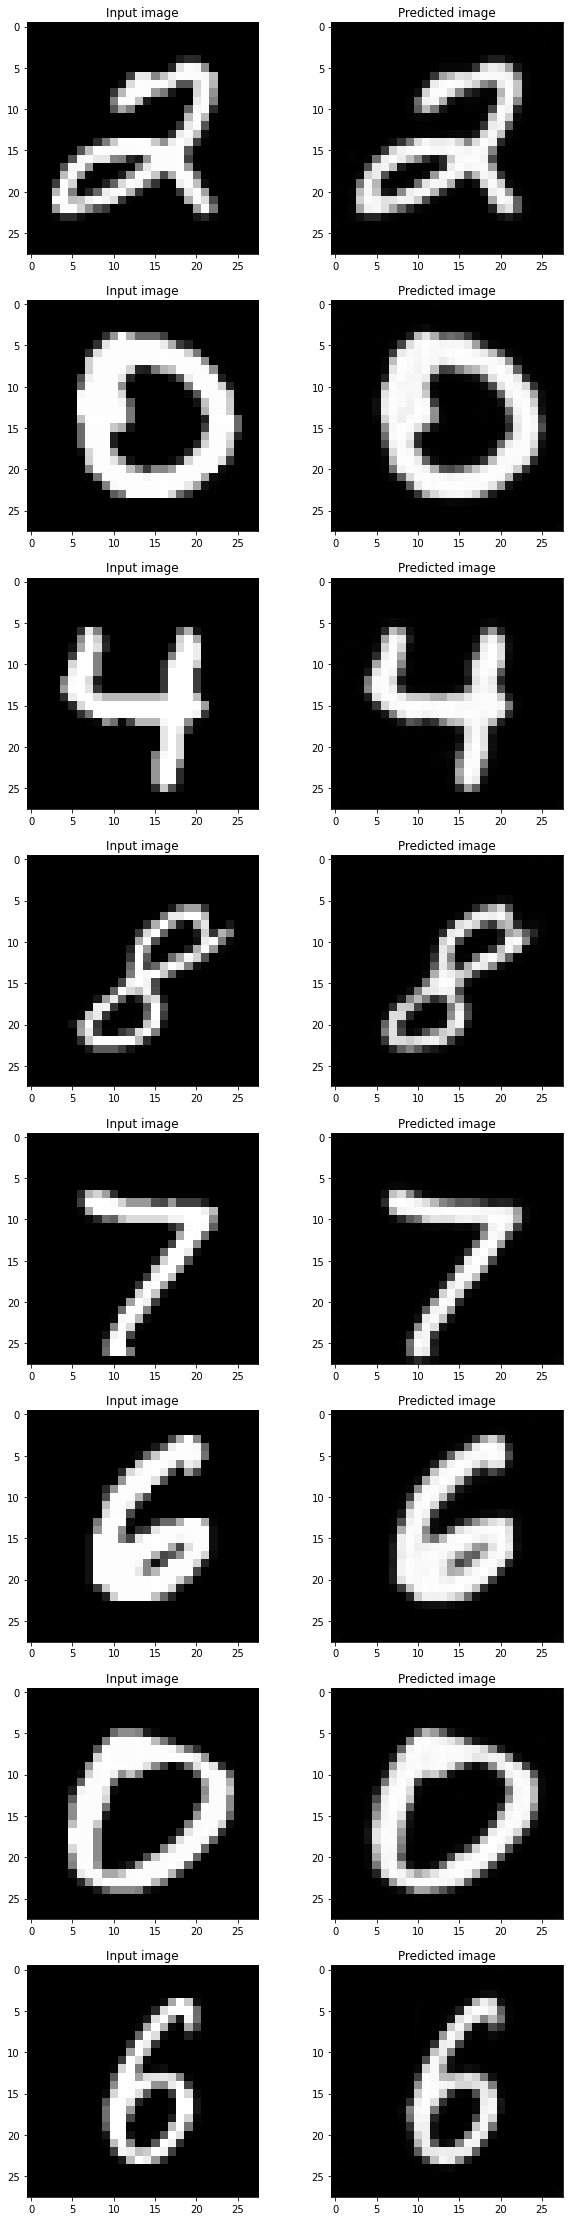

In [13]:
# get training dataset
print("[INFO] loading the training and validation datasets...")
train_ds = get_data(
    data_name=config.DATA_NAME,
    split=config.TRAIN_FLAG,
    shuffle_size=config.SHUFFLE_SIZE,
    batch_size=config.BATCH_SIZE
)

# get validation dataset
val_ds = get_data(
    data_name=config.DATA_NAME,
    split=config.VALIDATION_FLAG,
    shuffle_size=config.SHUFFLE_SIZE,
    batch_size=config.BATCH_SIZE
)

# init autoencoder model and compile it
print("[INFO] initializing the model...")
model = AutoEncoder()
mseloss = MSELoss(scale=1)
model.compile(loss=mseloss, optimizer=config.OPTIMIZER)

# train model
print("[INFO] training autoencoder...")
model.fit(
    train_ds,
    epochs=config.EPOCHS,
    steps_per_epoch=config.STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=config.VALIDATION_STEPS
)

# run inference
print("[INFO] running inference...")
(test_im, _) = next(iter(val_ds))

print("[INFO] evaluating model...")
pred_im = model.predict(test_im)

# create subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 40))

# iterate over subplots and fill with test+predicted images
for ax, real, pred in zip(axes, test_im[:8], pred_im[:8]):
    # plot input image
    ax[0].imshow(array_to_img(real), cmap="gray")
    ax[0].set_title("Input image")

    # plot predicted image
    ax[1].imshow(array_to_img(pred), cmap="gray")
    ax[1].set_title("Predicted image")

if not os.path.exists(config.BASE_IMG_PATH):
    os.makedirs(config.BASE_IMG_PATH)

print("[INFO] saving images...")
fig.savefig(config.CPU_IMG_PATH)

### Train with GPU
Runtime -> Change runtime type -> Hardware Accelerator -> GPU

In [11]:
from tensorflow.config import list_physical_devices

[INFO] number of available GPUs: 1
[INFO] loading the training and validation datasets...
[INFO] downloading the train split...
[INFO] downloading the test split...
[INFO] initializing the model...
[INFO] training autoencoder...
Epoch 1/5
468/468 [==============================] - 19s 16ms/step - loss: 0.0380 - val_loss: 0.0035
Epoch 2/5
468/468 [==============================] - 5s 11ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 3/5
468/468 [==============================] - 4s 9ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/5
468/468 [==============================] - 4s 9ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/5
468/468 [==============================] - 5s 11ms/step - loss: 0.0013 - val_loss: 0.0012
[INFO] running inference...
[INFO] evaluating model...
4/4 [==============================] - 0s 3ms/step
[INFO] saving images...


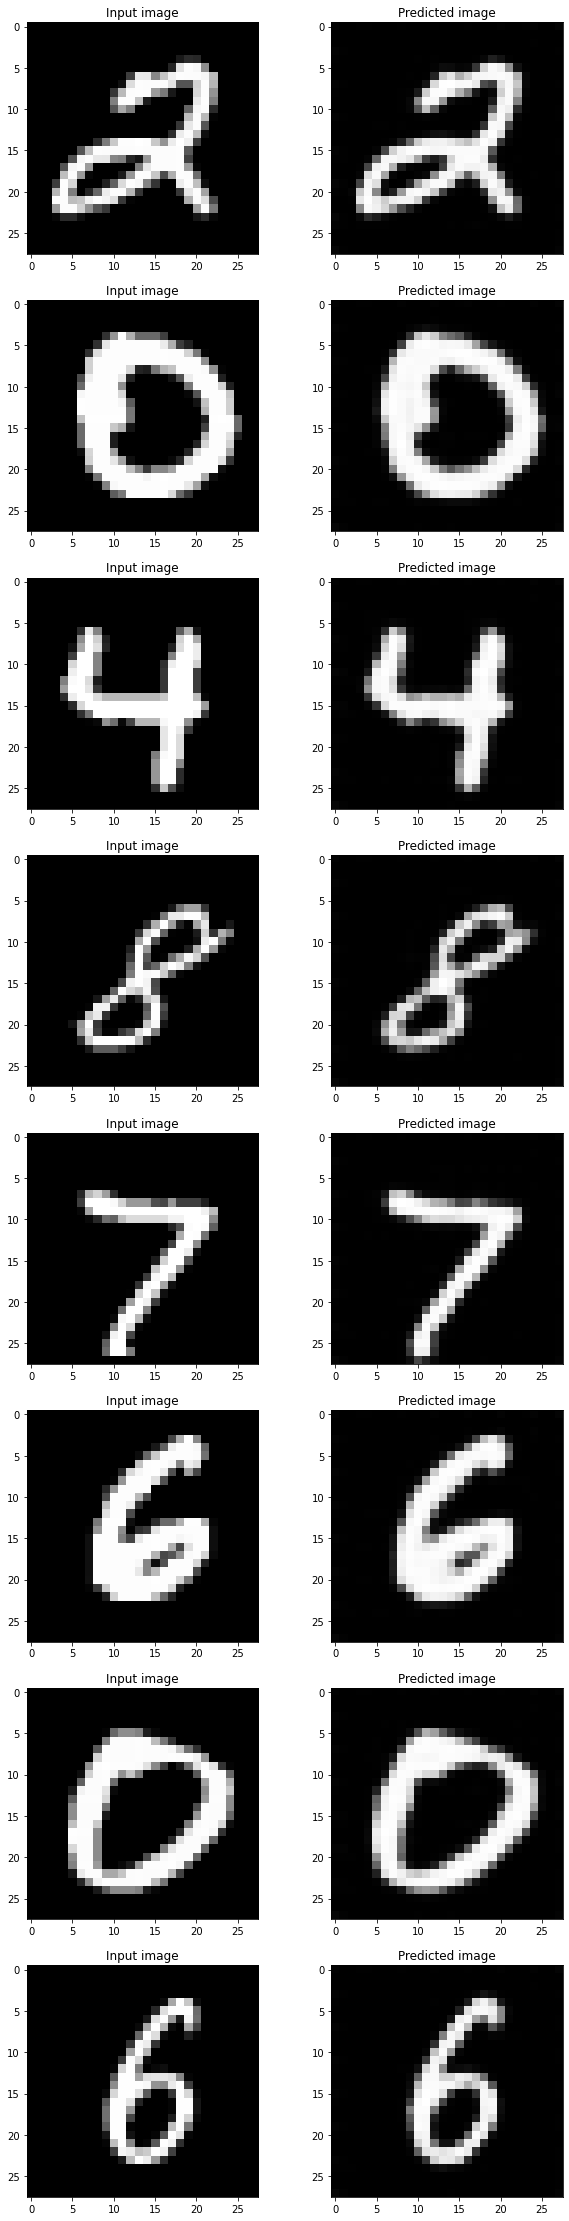

In [14]:
# check for GPU availability
num_gpu = len(list_physical_devices("GPU"))
print(f"[INFO] number of available GPUs: {num_gpu}")

# get training dataset
print("[INFO] loading the training and validation datasets...")
train_ds = get_data(
    data_name=config.DATA_NAME,
    split=config.TRAIN_FLAG,
    shuffle_size=config.SHUFFLE_SIZE,
    batch_size=config.BATCH_SIZE
)

# get validation dataset
val_ds = get_data(
    data_name=config.DATA_NAME,
    split=config.VALIDATION_FLAG,
    shuffle_size=config.SHUFFLE_SIZE,
    batch_size=config.BATCH_SIZE
)

# init autoencoder model and compile it
print("[INFO] initializing the model...")
model = AutoEncoder()
mseloss = MSELoss(scale=1)
model.compile(loss=mseloss, optimizer=config.OPTIMIZER)

# train model
print("[INFO] training autoencoder...")
model.fit(
    train_ds,
    epochs=config.EPOCHS,
    steps_per_epoch=config.STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=config.VALIDATION_STEPS
)

# run inference
print("[INFO] running inference...")
(test_im, _) = next(iter(val_ds))

print("[INFO] evaluating model...")
pred_im = model.predict(test_im)

# create subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 40))

# iterate over subplots and fill with test+predicted images
for ax, real, pred in zip(axes, test_im[:8], pred_im[:8]):
    # plot input image
    ax[0].imshow(array_to_img(real), cmap="gray")
    ax[0].set_title("Input image")

    # plot predicted image
    ax[1].imshow(array_to_img(pred), cmap="gray")
    ax[1].set_title("Predicted image")

if not os.path.exists(config.BASE_IMG_PATH):
    os.makedirs(config.BASE_IMG_PATH)

print("[INFO] saving images...")
fig.savefig(config.GPU_IMG_PATH)

### Train with TPU
Runtime -> Change runtime type -> Hardware Accelerator -> TPU

In [9]:
from tensorflow import distribute
from tensorflow.tpu.experimental import initialize_tpu_system
from tensorflow.config import experimental_connect_to_cluster

In [10]:
# init TPU and TPU strategy
tpu = distribute.cluster_resolver.TPUClusterResolver()
experimental_connect_to_cluster(tpu)
initialize_tpu_system(tpu)
strategy = distribute.TPUStrategy(tpu)

In [11]:
# get number of accelerators
num_acc = strategy.num_replicas_in_sync
print(f"[INFO] Number of accelerators: {num_acc}")

[INFO] Number of accelerators: 8


[INFO] loading the training and validation datasets...
[INFO] downloading the train split...
[INFO] downloading the test split...
[INFO] initializing the model...
[INFO] training autoencoder...
Epoch 1/5
58/58 [==============================] - 7s 77ms/step - loss: 0.1922 - val_loss: 0.1077
Epoch 2/5
58/58 [==============================] - 4s 67ms/step - loss: 0.0579 - val_loss: 0.0300
Epoch 3/5
58/58 [==============================] - 4s 65ms/step - loss: 0.0153 - val_loss: 0.0092
Epoch 4/5
58/58 [==============================] - 4s 65ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 5/5
58/58 [==============================] - 4s 65ms/step - loss: 0.0055 - val_loss: 0.0047
[INFO] running inference...
[INFO] evaluating model...
32/32 [==============================] - 0s 6ms/step
[INFO] saving images...


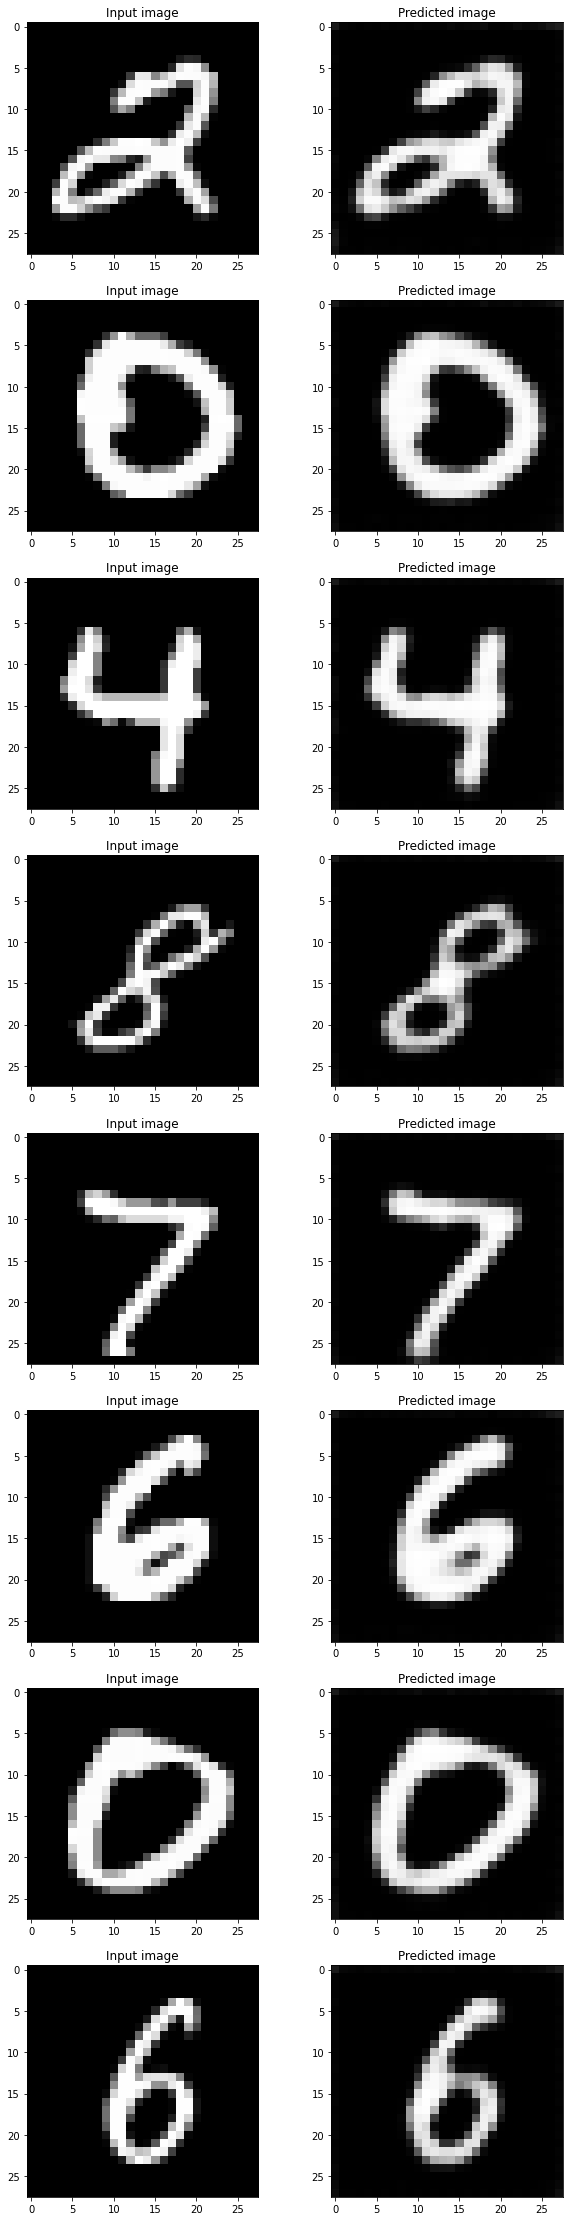

In [12]:

# get training dataset
print("[INFO] loading the training and validation datasets...")
train_ds = get_data(
    data_name=config.DATA_NAME,
    split=config.TRAIN_FLAG,
    shuffle_size=config.SHUFFLE_SIZE,
    batch_size=config.TPU_BATCH_SIZE
)

# get validation dataset
val_ds = get_data(
    data_name=config.DATA_NAME,
    split=config.VALIDATION_FLAG,
    shuffle_size=config.SHUFFLE_SIZE,
    batch_size=config.TPU_BATCH_SIZE
)

# init autoencoder model and compile it
print("[INFO] initializing the model...")
model = AutoEncoder()
mseloss = MSELoss(scale=1)
model.compile(loss=mseloss, optimizer=config.OPTIMIZER)

# train model
print("[INFO] training autoencoder...")
model.fit(
    train_ds,
    epochs=config.EPOCHS,
    steps_per_epoch=config.TPU_STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=config.TPU_VALIDATION_STEPS
)

# run inference
print("[INFO] running inference...")
(test_im, _) = next(iter(val_ds))

print("[INFO] evaluating model...")
pred_im = model.predict(test_im)

# create subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 40))

# iterate over subplots and fill with test+predicted images
for ax, real, pred in zip(axes, test_im[:8], pred_im[:8]):
    # plot input image
    ax[0].imshow(array_to_img(real), cmap="gray")
    ax[0].set_title("Input image")

    # plot predicted image
    ax[1].imshow(array_to_img(pred), cmap="gray")
    ax[1].set_title("Predicted image")

if not os.path.exists(config.BASE_IMG_PATH):
    os.makedirs(config.BASE_IMG_PATH)

print("[INFO] saving images...")
fig.savefig(config.TPU_IMG_PATH)